In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from mammo_utils import random_flip_image
import os
%matplotlib inline

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load the data
train_cbis_slices = np.load(os.path.join("data", "cbis_train_slices12.npy"))
train_cbis_labels = np.load(os.path.join("data", "cbis_train_labels12.npy"))
train_cbis_filenames = np.load(os.path.join("data", "cbis_train_names12.npy"))

test_cbis_slices = np.load(os.path.join("data", "cbis_test_slices12.npy"))
test_cbis_labels = np.load(os.path.join("data", "cbis_test_labels12.npy"))
test_cbis_filenames = np.load(os.path.join("data", "cbis_test_names12.npy"))

print("CBIS Train Images:", train_cbis_slices.shape)
print("CBIS Test Images:", test_cbis_slices.shape)

CBIS Train Images: (36755, 320, 320, 1)
CBIS Test Images: (10055, 320, 320, 1)


In [3]:
train_cbis_slices[0].dtype

dtype('uint8')

In [4]:
# create the test data - in order to make sure the data sets don't overlap we will splt the cbis images evenly into test
# and validation now. In order to try to segregate images by patient we will just split the data down the middle. 
# Since each mask can have at most 4 images this should keep overlap to a minimum
test_size = test_cbis_slices.shape[0] // 2

split_test_cbis_slices = test_cbis_slices[:test_size,:,:,:]
split_cv_cbis_slices = test_cbis_slices[test_size:,:,:,:]

split_test_cbis_labels = test_cbis_labels[:test_size]
split_cv_cbis_labels = test_cbis_labels[test_size:]

split_test_cbis_filenames = test_cbis_filenames[:test_size]
split_cv_cbis_filenames = test_cbis_filenames[test_size:]

print("Test Images:", split_test_cbis_slices.shape)
print("CV Images:", split_cv_cbis_slices.shape)

print("Test Labels:", split_test_cbis_labels.shape)
print("CV Labels:", split_cv_cbis_labels.shape)

Test Images: (5027, 320, 320, 1)
CV Images: (5028, 320, 320, 1)
Test Labels: (5027, 320, 320, 1)
CV Labels: (5028, 320, 320, 1)


## Shuffle the data and split it

In [5]:
# shuffle the training data
X_tr, y_tr, train_filenames = shuffle(train_cbis_slices, train_cbis_labels, train_cbis_filenames, random_state=7241972)

# shuffle the test data
X_te, y_te, test_filenames = shuffle(split_test_cbis_slices, split_test_cbis_labels, split_test_cbis_filenames, random_state=228859)

# shuffle the cv data
X_cv, y_cv, cv_filenames = shuffle(split_cv_cbis_slices, split_cv_cbis_labels, split_cv_cbis_filenames, random_state=21777)


print("X_tr", X_tr.shape)
print("X_te", X_te.shape)
print("X_cv", X_cv.shape)

X_tr (36755, 320, 320, 1)
X_te (5027, 320, 320, 1)
X_cv (5028, 320, 320, 1)


In [6]:
## save the test data
np.save(os.path.join("data", "test12_data.npy"), X_te)
np.save(os.path.join("data", "test12_labels.npy"), y_te)
np.save(os.path.join("data", "test12_filenames.npy"), test_filenames)

In [7]:
# save the validation data
np.save(os.path.join("data", "cv12_data.npy"), X_cv)
np.save(os.path.join("data", "cv12_labels.npy"), y_cv)
np.save(os.path.join("data", "cv12_filenames.npy"), cv_filenames)

In [8]:
del(X_te, y_te, X_cv, y_cv)

In [9]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [10]:
# write train data to tfrecords in 5 batches
import math
num_batches = 5
batch_size = math.ceil(X_tr.shape[0] / num_batches)

for i in range(num_batches):
    train_path = os.path.join("data","training12_" + str(i) + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(train_path)
    start_row = i * batch_size
    end_row = start_row + batch_size - 1
                              
    for idx in range(start_row, end_row):
        # try to get the data, if there is an error skip this index
        try:
            label = y_tr[idx]
            label_raw = label.tostring()
            image = X_tr[idx]
            image_raw = image.tostring()
        except:
            continue
            
        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': _bytes_feature(label_raw),
                'image': _bytes_feature(image_raw),
              }))

        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)

## Verify that the data was written correctly

In [2]:
# make sure everything was written properly by reading it back out
def read_and_decode_single_example(filenames):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.string),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = tf.decode_raw(features['label'], tf.uint8)
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [320, 320, 1])
    label = tf.reshape(label, [320, 320, 1])
    
    return label, image

In [3]:
label, image = read_and_decode_single_example(["data/training12_0.tfrecords", "data/training12_1.tfrecords"])

#images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)
images_batch, labels_batch = tf.train.batch([image, label], batch_size=16, capacity=2000)

# contrast_img = tf.image.adjust_contrast(images_batch, 2.0)
la_max = tf.reduce_max(labels_batch, axis=[1,2])

# class_weight = tf.constant([4.0,1.0,1.0,1.0, 1.0])
# weight_per_label = tf.transpose(tf.matmul(tf.cast(tf.one_hot(labels_batch, depth=5), tf.float32), tf.transpose(class_weight)))

global_step = tf.Variable(0, trainable=False)

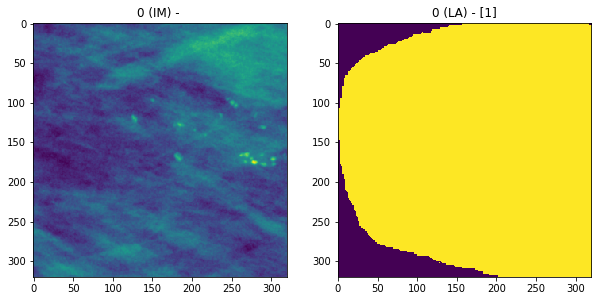

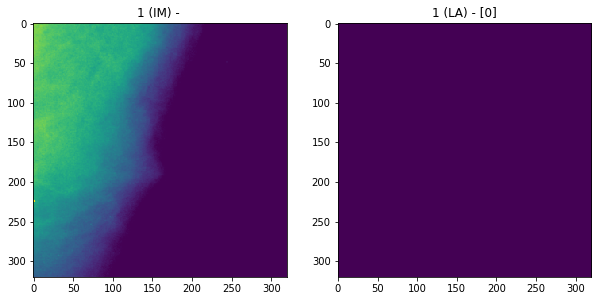

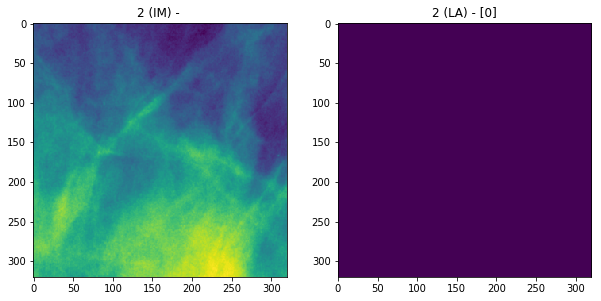

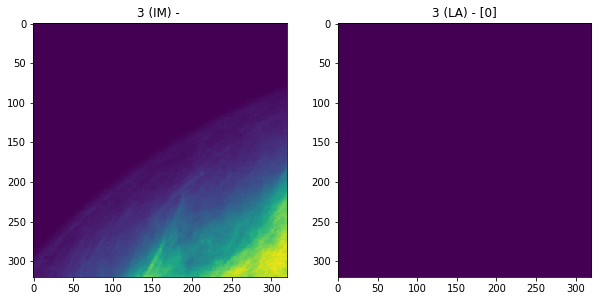

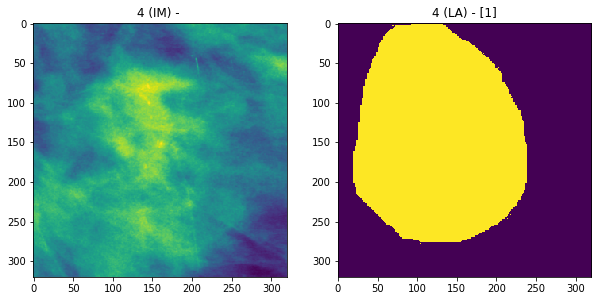

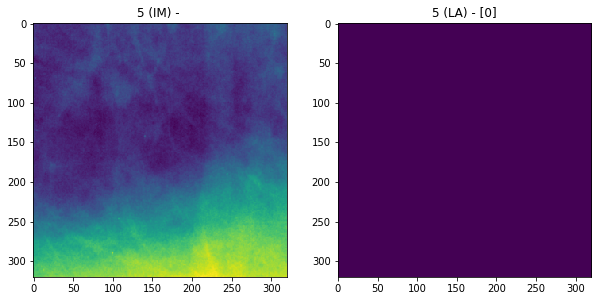

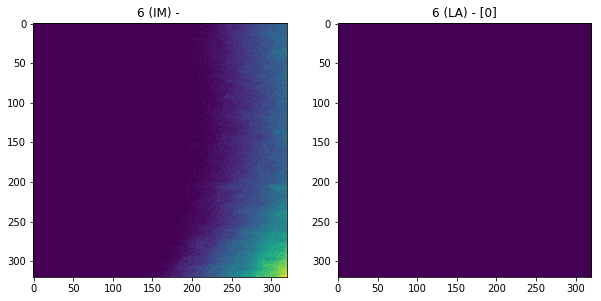

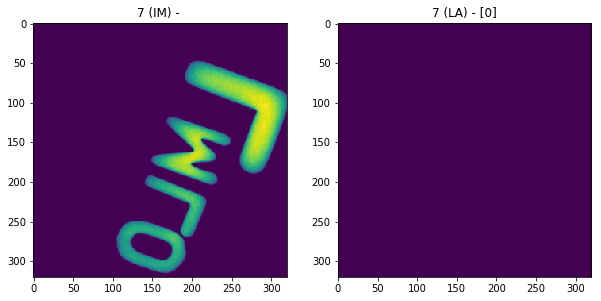

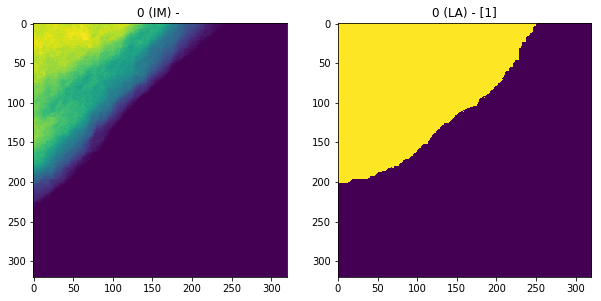

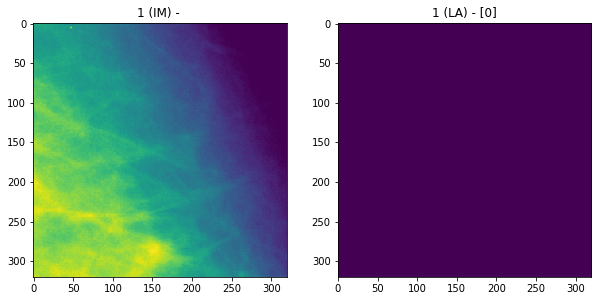

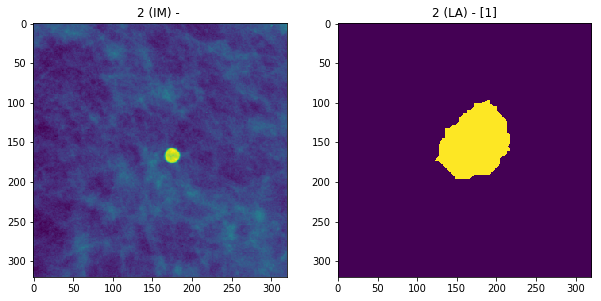

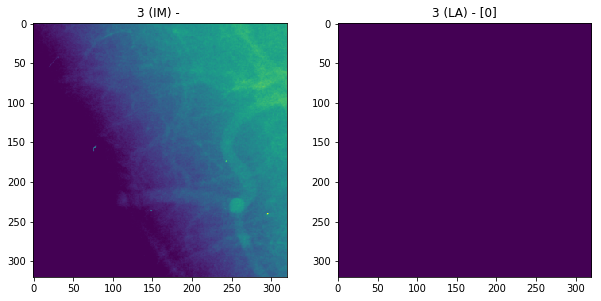

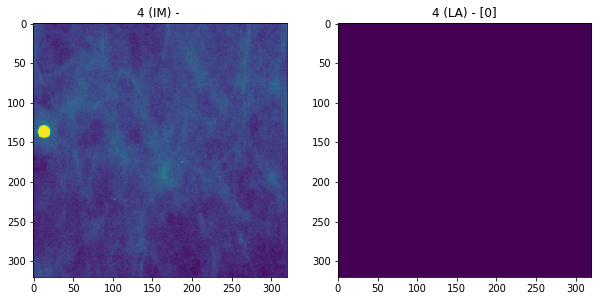

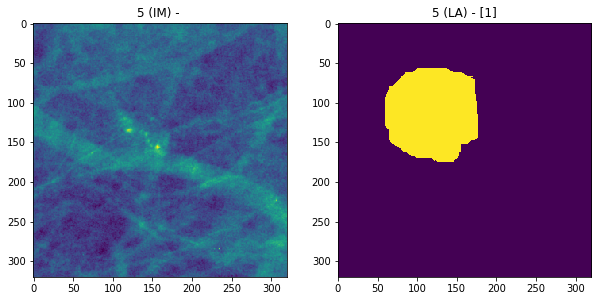

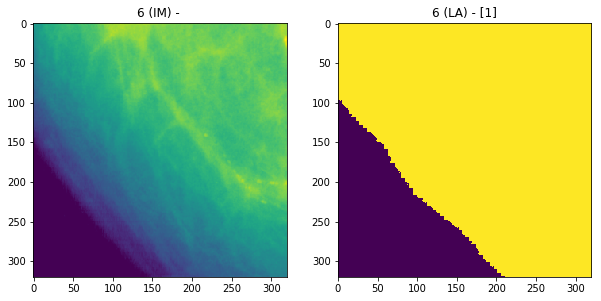

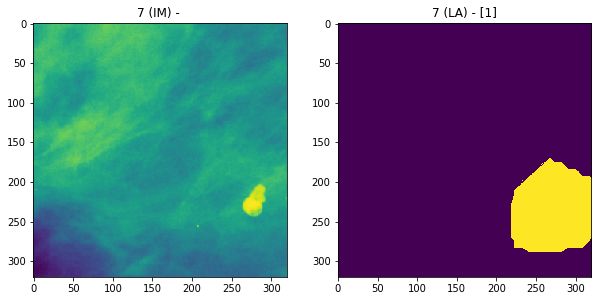

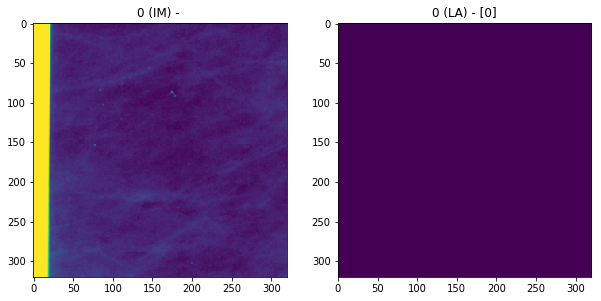

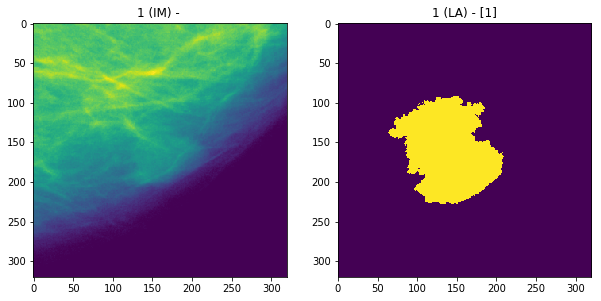

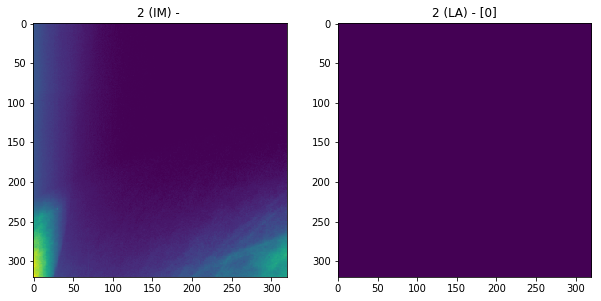

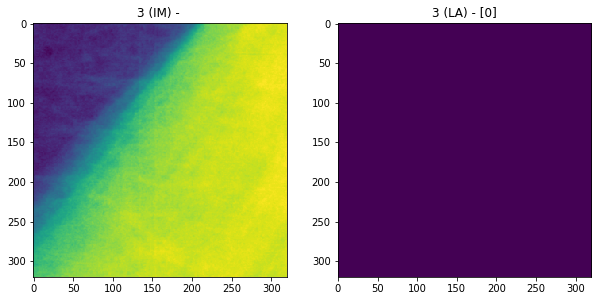

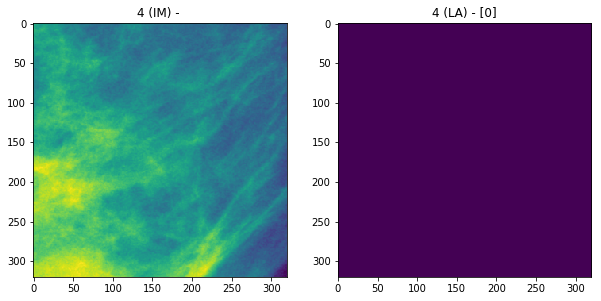

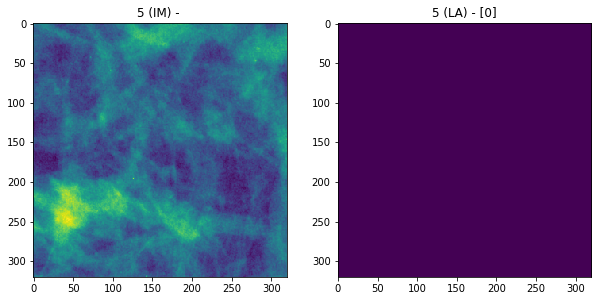

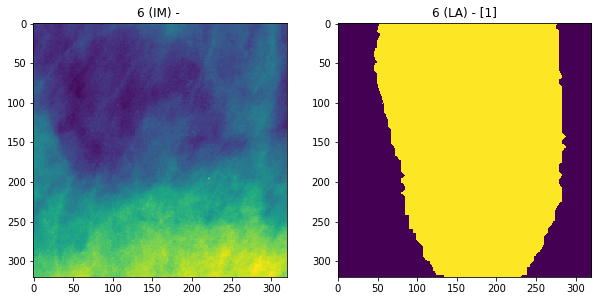

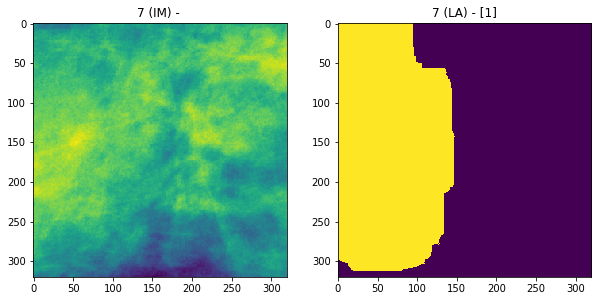

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for j in range(3):
        la_b, im_b, bar = sess.run([labels_batch, images_batch, la_max])
        
        for i in range(8):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            ax[0].imshow(im_b[i].reshape([320,320]))
            ax[0].set_title(str(i) + " (IM) - ")
            
            ax[1].imshow(la_b[i].reshape([320,320]))
            ax[1].set_title(str(i) + " (LA) - " + str(bar[i]))
            plt.show()
            
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)